# Data analysis single cell 

This tutorial want to show a possible analysis worflow starting from census data
For simplicity we will start from a single dataset, and we will perform the most common quality control metrics. 
1. 

In this case we decide to use the dataset contained in Tabula Muris Collection regarding bone marrow

In [1]:
# first you need to know the dataset IDs 
import cellxgene_census

census = cellxgene_census.open_soma()

The "stable" release is currently 2024-07-01. Specify 'census_version="2024-07-01"' in future calls to open_soma() to ensure data consistency.


By default the census retrieve the raw data. X_name can be either set to 'raw' or normalized.

In [2]:
adata_raw = cellxgene_census.get_anndata(
    census,organism ="homo sapiens",  obs_value_filter="dataset_id == '00ff600e-6e2e-4d76-846f-0eec4f0ae417'", X_name = 'raw'
)

adata_raw

AnnData object with n_obs × n_vars = 363 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

### Quality control metrics

By default census downloads the raw data, which means that before proceeeding with the downstream analysis of interest it is necessary to check QC metrics. 

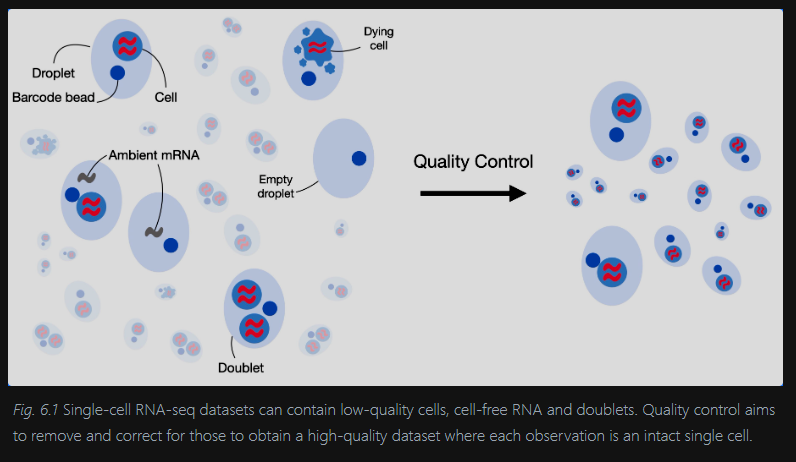

The first step in quality control is to remove low-quality cells from the dataset. When a cell has a low number of detected genes, a low count depth and a high fraction of mitochondrial counts it might have a broken membrane which can indicate a dying cell. As these cells are usually not the main target of our analysis and might distort our downstream analysis, we are removing them during quality control. For identifying them, we define cell quality control (QC) threshold. Cell QC is typically performed on the following three QC covariates:

1. The number of counts per barcode (count depth)

2. The number of genes per barcode

3. The fraction of counts from mitochondrial genes per barcode

In cell QC these covariates are filtered via thresholding as they might correspond to dying cells. As indicated, they might reflect cells with broken membranes whose cytoplasmic mRNA has leaked out and therefore only the mRNA in the mitochondria is still present. These cells might then show a low count depth, few detected genes and a high fraction of mitochondrial reads. It is, however, crucial to consider the three QC covariates jointly as otherwise it might lead to misinterpretation of cellular signals. 

In QC, the first step is to calculate the QC covariates or metric. We compute these using the scanpy function sc.pp.calculate_qc_metrics, which can also calculate the proportions of counts for specific gene populations. We therefore define mitochondrial, ribosomal and hemoglobin genes. It is important to note that mitochondrial counts are annotated either with the prefix “mt-” or “MT-’’ depending on the species considered in the dataset. As mentioned, the dataset used in this notebook is human bone marrow, so mitochondrial counts are annotated with the prefix “MT-”. For mouse datasets, the prefix is usually lower case, so “mt-“.

In [3]:
import numpy as np

In [4]:
adata = adata_raw

In [5]:
# mitochondrial genes
adata.var["mt"] = adata.var.feature_name.str.startswith("MT")
# ribosomal genes
adata.var["ribo"] = adata.var.feature_name.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var.feature_name.str.contains("HB")

In [6]:
import scanpy as sc
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 363 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n

The following plot helps to understand whether some QC metrics has been applied or not

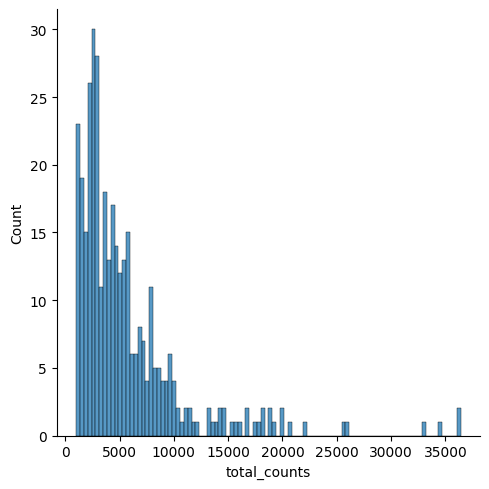

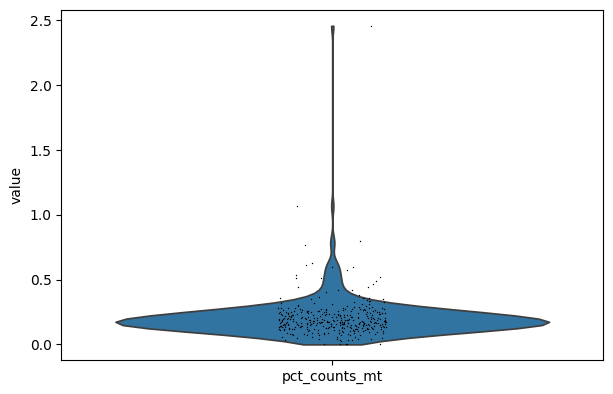

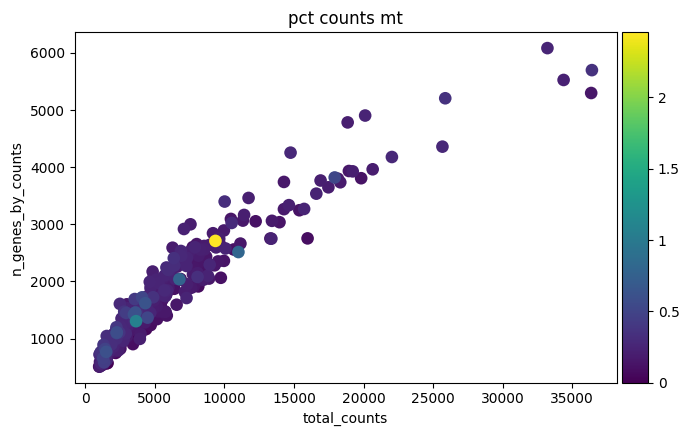

In [ ]:
import seaborn as sns 
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Low total_counts or gene count suggest low RNA content or dead cells.
High pct_counts_mt suggest unhealthy cells with compromised membranes.

### It seems that some QC metrics has been already applied! 
Cells with low total cout have been cutted, and cells with high percentage of mitocondrial reads has been discarded. 

In [17]:
# I retrieve again the data for simplicity
adata_raw = cellxgene_census.get_anndata(
    census,organism ="homo sapiens",  obs_value_filter="dataset_id == '00ff600e-6e2e-4d76-846f-0eec4f0ae417'", X_name = 'raw'
)

adata_raw

AnnData object with n_obs × n_vars = 363 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

Now let’s do some basic normalization:

1. Transform to log-scale

2. Select 500 highly variable genes

3. Scale values across the gene axis

In [18]:
# I do a check on any Nan or infinite values 
import numpy as np

# Check for infinite values
if np.any(np.isinf(adata_raw.X.todense())):
    print("Infinite values found in adata.X")

# Check for NaN values
if np.any(np.isnan(adata_raw.X.todense())):
    print("NaN values found in adata.X")


In [19]:
import scanpy as sc

In [20]:
# Check for infinite values
if np.any(np.isinf(adata_raw.X.todense())):
    print("Infinite values found in adata.X")

# Check for NaN values
if np.any(np.isnan(adata_raw.X.todense())):
    print("NaN values found in adata.X")

In [21]:
adata_raw.X = adata_raw.X.todense()

/opt/conda/envs/cellxgene/lib/python3.10/site-packages/anndata/_core/storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


In [22]:
# Check for infinite values
if np.any(np.isinf(adata_raw.X)):
    print("Infinite values found in adata.X")

# Check for NaN values
if np.any(np.isnan(adata_raw.X)):
    print("NaN values found in adata.X")

In [23]:
# Step 4: Logarithmic transformation
sc.pp.log1p(adata_raw)

In [24]:
# Step 2: Identify highly variable genes
sc.pp.highly_variable_genes(adata_raw, min_mean=0.0125, max_mean=10, min_disp=0.5, n_bins=20)

In [25]:
adata_raw = adata_raw[:, adata_raw.var['highly_variable']== True]

Calcolo delle metrics utili per fare i plot successivi

In [26]:
sc.tl.pca(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.umap(adata_raw)

/opt/conda/envs/cellxgene/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/opt/conda/envs/cellxgene/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


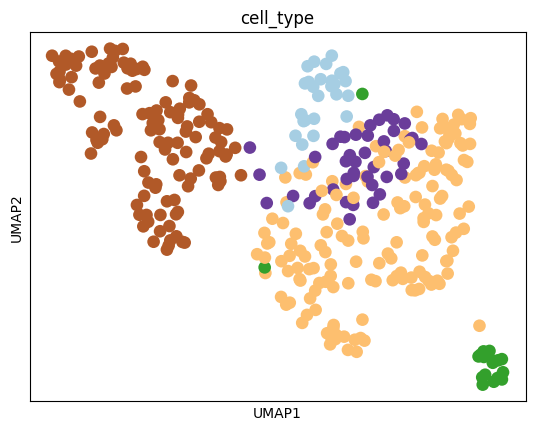

In [29]:
sc.pl.umap(adata_raw, color="cell_type", palette='Paired', legend_loc=None)

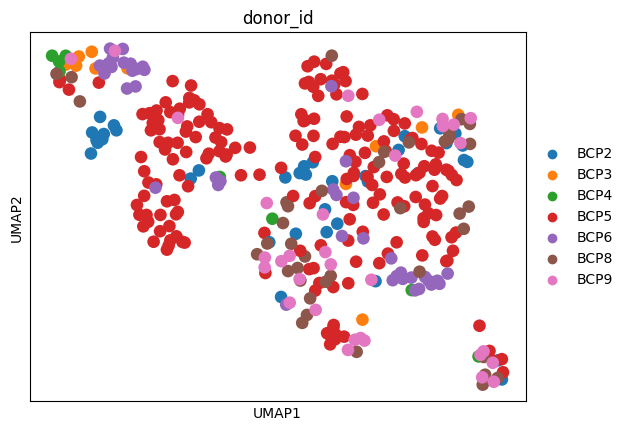

In [31]:
sc.pl.umap(adata_raw, color= 'donor_id')